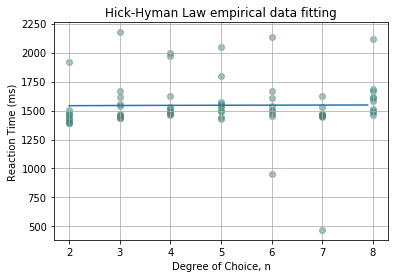

In [12]:
# ============================================================================
# Author  : Jiayao Yu, User Interfaces Group, Aalto University
# Init    : August, 2017
# Project : ELEC-D7010 Engineering for Humans course materials
# Topic   : Hick-Hyman Law
# ============================================================================

# ============================================================================
# Usage explaination
# ============================================================================

import tkinter as tk
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import random
import time as tm

class ExpAccurate(tk.Frame):
	# initial parameters
	gameAreaHeight = 300
	stimuliBasePosition = [200, -30]
	stimuliSideLength = 30
	stimuliFontSize = 20
	stimuliKey = ['S', 'L', 'E', 'I', 'R', 'U', 'G', 'H']
	stimuliTotalAmount = 8
	timeStart = []                                  # list of timestamp when generating each stimulus
	timeHit = []                                    # list of timestamp when hit each correct key
	timeDelta = []                                  # list of reaction time in millisecond
	plotTimeXList = []                              # list of stimuli amount as abscissa in plot RT ~ f(N)
	clips = 0
	plotTimeXClips = []								# list of amount of valid reaction time logs with regard to each timuli set size
	counterMax = 10                                  # to limit repeating times of hit-key experiment for a certain stimuli set size
	flagPause = False
	flagTransit = False
	flagStart = False
	coefficient_determination = 0.0

	def __init__(self, parent=None):
		tk.Frame.__init__(self, parent)
		self.pack()
		self.makeWidgets()
		self.defStimuliCollection()
		self.stimuliAmount = 2						# initial stimuli amount
		self.counter = 0							# to record repeating times of hit-key experiment so far

		self.flagStart = False
		self.flagPause = False
		self.flagTransit = False

		self.bind_all('<space>', self.start)		# press <space> to start the experiment

	def makeWidgets(self):
		self.frameExplain = tk.Frame(self)
		self.frameGameArea = tk.Canvas(self, bd=2, bg='white', relief=tk.GROOVE, width=500, height=self.gameAreaHeight)
		self.frameControlPanel = tk.Frame(self)

		self.frameExplain.grid(row=0, column=0, padx=10, pady=10)
		self.frameGameArea.grid(row=1, column=0, padx=10, pady=10)
		self.frameGameArea.grid_propagate(0)
		self.frameControlPanel.grid(row=0, rowspan=2, column=1, padx=10, pady=10)
		
		self.labelPause = tk.Label(self.frameExplain, text="Press <SPACE> key to START")
		# stimuli hints
		self.stimuliHints = [0 for x in range(8)]
		for x in range(8):
			self.stimuliHints[x] = tk.Label(self.frameExplain, text=self.stimuliKey[x], relief=tk.GROOVE, width=5)
		self.labelRequirement = tk.Label(self.frameControlPanel, text="If checked, stimuli are dropping, otherwise they are still", wraplength=200)
		# toggle stimuli dropping animation
		self.varToggle = tk.IntVar()
		self.btnToggleMode = tk.Checkbutton(self.frameControlPanel, text="Stimuli animation", variable=self.varToggle)
		self.btnPreload = tk.Button(self.frameControlPanel, text="Preload Dataset")
		# self.btnFilter = tk.Button(self.frameControlPanel, text="Filter Outliers", state=tk.DISABLED)
		self.btnFilter = tk.Button(self.frameControlPanel, text="Filter Outliers")
		self.labelRSquare = tk.Label(self.frameControlPanel, text="R-square = ")

		self.labelPause.grid(row=0, column=0, columnspan=8, padx=10, sticky=tk.W)
		self.stimuliHints[0].grid(row=2, column=0, sticky=tk.NSEW, padx=10, pady=10)
		self.stimuliHints[1].grid(row=2, column=7, sticky=tk.NSEW, padx=10, pady=10)
		self.stimuliHints[2].grid(row=1, column=1, sticky=tk.NSEW, padx=10, pady=10)
		self.stimuliHints[3].grid(row=1, column=6, sticky=tk.NSEW, padx=10, pady=10)
		self.stimuliHints[4].grid(row=1, column=2, sticky=tk.NSEW, padx=10, pady=10)
		self.stimuliHints[5].grid(row=1, column=5, sticky=tk.NSEW, padx=10, pady=10)
		self.stimuliHints[6].grid(row=2, column=3, sticky=tk.NSEW, padx=10, pady=10)
		self.stimuliHints[7].grid(row=2, column=4, sticky=tk.NSEW, padx=10, pady=10)
		self.labelRequirement.grid(row=0, column=0, padx=10, pady=10)
		self.btnPreload.grid(row=2, column=0, sticky=tk.NSEW, padx=10, pady=10)
		self.btnToggleMode.grid(row=1, column=0, sticky=tk.NSEW, padx=10, pady=10)
		self.btnFilter.grid(row=3, column=0, sticky=tk.NSEW, padx=10, pady=10)
		self.labelRSquare.grid(row=4, column=0, sticky=tk.W, padx=10, pady=10)

		self.btnPreload.bind('<ButtonRelease-1>', self.preload)
		self.btnFilter.bind('<ButtonRelease-1>', self.filter)

	def defStimuliCollection(self):
		self.stimuli = [0 for x in range(8)]
		self.stimuliTexts = [0 for x in range(8)]
		for x in range(8):
			self.stimuli[x] = self.frameGameArea.create_rectangle(self.stimuliBasePosition[0], self.stimuliBasePosition[1], self.stimuliBasePosition[0] + self.stimuliSideLength, self.stimuliBasePosition[1] + self.stimuliSideLength, fill='#C0FFF8', activefill='#63B2A9', tags=self.stimuliKey[x], state=tk.HIDDEN)
			self.stimuliTexts[x] = self.frameGameArea.create_text(self.stimuliBasePosition[0] + 0.5*self.stimuliSideLength, self.stimuliBasePosition[1] + 0.5*self.stimuliSideLength, text=self.stimuliKey[x], font=self.stimuliFontSize, tags=self.stimuliKey[x], state=tk.HIDDEN)

	def start(self, event):
		self.flagStart = True
		self.generateStimuliSet(self.stimuliAmount)
		self.bind_all('<KeyPress>', self.onKeyHit)
		self.bind_all('<space>', self.pauseResume)

	def generateStimuliSet(self, argAmount):
		self.plotTimeXClips.append(self.clips)
		self.flagTransit = True
		self.indexList = []				# currently activated indices of stimuli
		for i in range(argAmount):
			self.indexList.append(i)
			self.stimuliHints[i].config(relief=tk.RAISED, bg='#63B2A9', fg='white')
		self.speed = 5
		self.counterTransit = 0
		self.transitStimuliSet()

	def transitStimuliSet(self):
		# blink updated stimuli set twice
		if self.counterTransit < 4:
			if self.stimuliHints[0].cget('state') == tk.NORMAL:
				for i in range(self.stimuliAmount):
					self.stimuliHints[i].config(state=tk.DISABLED, bg='SystemButtonFace', relief=tk.GROOVE)
			else:
				for i in range(self.stimuliAmount):
					self.stimuliHints[i].config(state=tk.NORMAL, bg='#63B2A9', relief=tk.RAISED)
			self.counterTransit += 1
			self.frameGameArea.after(500, self.transitStimuliSet)
		else:
			self.frameGameArea.after(1500, self.generateRandomStimuli(self.indexList))

	def generateRandomStimuli(self, argIndexList):
		self.indexCurrent = random.sample(argIndexList, 1)
		self.frameGameArea.itemconfigure(self.stimuli[self.indexCurrent[0]], state=tk.NORMAL)
		self.frameGameArea.itemconfigure(self.stimuliTexts[self.indexCurrent[0]], state=tk.NORMAL)
		self.frameGameArea.coords(self.stimuli[self.indexCurrent[0]], self.stimuliBasePosition[0], self.stimuliBasePosition[1], self.stimuliBasePosition[0] + self.stimuliSideLength, self.stimuliBasePosition[1] + self.stimuliSideLength)
		self.frameGameArea.coords(self.stimuliTexts[self.indexCurrent[0]], self.stimuliBasePosition[0] + 0.5*self.stimuliSideLength, self.stimuliBasePosition[1] + 0.5*self.stimuliSideLength)

		self.flagTransit = False
		if self.flagStart == True:
			self.animateStimuli()
			self.flagStart = False
		# record the timestamp when generating this stimulus
		self.timeStart.append(tm.clock())

	# animate the dropping of stimuli 
	def animateStimuli(self):
		# press <space> can pause/resume animateStimuli()
		if self.flagPause == False:
			if self.flagTransit == False:
				# if choose to drop stimuli
				if self.varToggle.get() == 1:
					if self.frameGameArea.coords(self.stimuli[self.indexCurrent[0]])[1] > self.gameAreaHeight + 3:
						# the user doesn't hit the correct key until the stimuli drops out, so deleting invalid starting time log for this stimuli
						del(self.timeStart[-1])

						if self.counter < self.counterMax - 1:
							self.generateRandomStimuli(self.indexList)
							self.counter += 1
						else:
							if self.stimuliAmount < 8:
								self.counter = 0
								self.stimuliAmount += 1
								self.generateStimuliSet(self.stimuliAmount)
							else:
								self.flagPause = True
								self.expEnd()
					else:	
						self.frameGameArea.move(self.stimuli[self.indexCurrent[0]], 0, self.speed)
						self.frameGameArea.move(self.stimuliTexts[self.indexCurrent[0]], 0, self.speed)
				# if choose to still stimuli
				else:
					self.frameGameArea.coords(self.stimuli[self.indexCurrent[0]], 250-0.5*self.stimuliSideLength, 
						0.5*(self.gameAreaHeight-self.stimuliSideLength), 250+0.5*self.stimuliSideLength, 0.5*(self.gameAreaHeight+self.stimuliSideLength))
					self.frameGameArea.coords(self.stimuliTexts[self.indexCurrent[0]], 250, 0.5*self.gameAreaHeight)
					if(len(self.timeStart)):
						if(tm.clock()-self.timeStart[-1]) > 3:
							self.disappearStimuli()
			self.frameGameArea.after(20, self.animateStimuli)

	def disappearStimuli(self):
		self.frameGameArea.itemconfigure(self.stimuli[self.indexCurrent[-1]], state=tk.HIDDEN, fill='#C0FFF8')
		self.frameGameArea.itemconfigure(self.stimuliTexts[self.indexCurrent[-1]], state=tk.HIDDEN)
		if self.counter < self.counterMax - 1:
			self.generateRandomStimuli(self.indexList)
			self.counter += 1
		else:
			if self.stimuliAmount < 8:
				self.counter = 0
				self.stimuliAmount += 1
				self.generateStimuliSet(self.stimuliAmount)
			else:
				self.flagPause = True
				self.expEnd()

	def onKeyHit(self, event):
		if self.flagPause == False:
			self.indexHit = []
			if event.char == self.stimuliKey[self.indexCurrent[0]] or event.char == self.stimuliKey[self.indexCurrent[0]].lower():
				self.indexHit.append(self.indexCurrent[0])
				self.timeHit.append(tm.clock())
				self.timeDelta.append((self.timeHit[-1] - self.timeStart[-1])*1000)
				self.plotTimeXList.append(self.stimuliAmount)
				self.clips += 1
				self.frameGameArea.itemconfigure(self.stimuli[self.indexCurrent[0]], fill='#63B2A9')
				self.flagPause = True
				self.flagTransit = True
				self.frameGameArea.after(300, self.afterCorrectKeyHit)
				print("hit corrected key!")

	def afterCorrectKeyHit(self):
		self.flagTransit = False
		self.frameGameArea.itemconfigure(self.stimuli[self.indexCurrent[0]], state=tk.HIDDEN, fill='#C0FFF8')
		self.frameGameArea.itemconfigure(self.stimuliTexts[self.indexCurrent[0]], state=tk.HIDDEN)
		self.flagPause = False
		self.frameGameArea.after(1000, self.animateStimuli)
		# repeat generateRandomStimuli()
		if self.counter < self.counterMax - 1:
			self.generateRandomStimuli(self.indexList)
			self.counter += 1
			# plot reaction time against stimuli set size
			fig = plt.figure()
			graph = fig.add_subplot(1,1,1)
			graph.set(title="Hick-Hyman Law empirical data fitting", ylabel="Reaction Time (ms)", xlabel="Degree of Choice, n")
			graph.scatter(self.plotTimeXList, self.timeDelta, color='#4A857E', alpha=0.5)
			plt.xticks(range(min(self.plotTimeXList)-1, max(self.plotTimeXList)+2, 1))
			plt.grid()
			display.clear_output(wait=True)
			plt.show()
		else:
			# increase the size of stimuli set
			if self.stimuliAmount < 8:
				self.counter = 0
				self.stimuliAmount += 1
				self.generateStimuliSet(self.stimuliAmount)
			else:
				self.flagPause = True
				self.expEnd()

	def pauseResume(self, event):
		if self.flagTransit == False:
			self.flagPause = not self.flagPause
			self.animateStimuli()
			if self.flagPause == True:
				self.labelPause.config(text="Press <SPACE> key to CONTINUE")
			else:
				self.labelPause.config(text="Press <SPACE> key to PAUSE at any time")

	def expEnd(self):
		self.unbind_all('<KeyPress>')
		# plot reaction time against stimuli set size
		fig, ax = plt.subplots()
		ax.set(title="Hick-Hyman Law empirical data fitting", ylabel="Reaction Time (ms)", xlabel="Degree of Choice, n")
		plt.scatter(self.plotTimeXList, self.timeDelta, color='#4A857E', alpha=0.5)
		plt.xticks(range(min(self.plotTimeXList)-1, max(self.plotTimeXList)+2, 1))
		plt.grid()	
		# empirical data fitting
		plotTimeXLogList = np.log2(self.plotTimeXList)
		z = np.polyfit(plotTimeXLogList, self.timeDelta, 1)
		f = np.poly1d(z)
		plotTimeXArray = np.array(self.plotTimeXList)
		x = np.arange(plotTimeXArray.min(), plotTimeXArray.max(), 0.1)
		xLog = np.log2(x)
		y = f(xLog)
		plt.plot(x, y)
		# compute R-squared (coefficient of determination)
		ybar = np.mean(f(self.plotTimeXList))
		sstot, ssres = (0 for i in range(2))
		for i in range(len(self.timeDelta)):
			sstot += (self.timeDelta[i] - ybar)**2
			ssres += (f(self.plotTimeXList[i] - self.timeDelta[i]))**2
		self.coefficient_determination = 1 - ssres/sstot
		display.clear_output(wait=True)
		plt.show()
		self.btnFilter.config(state=tk.NORMAL)

	def preload(self, event):
		self.timeDelta = [1,1,1,1,8,2,3,4,5,6,6,6,7,8]
		self.plotTimeXList = [1,1,1,1,1,2,3,4,5,6,6,6,7,8]
		self.expEnd()

	def filter(self, event):
		tmpTimeDelta, tmpPlotTimeXList = ([] for i in range(2))
		tmpPlotTimeX_Ref = self.plotTimeXList[0]
		tmpTimeDelta_filtering, tmpPlotTimeX_filtering = ([] for i in range(2))
		for i in range(len(self.timeDelta)):
			if self.plotTimeXList[i] == tmpPlotTimeX_Ref:
				tmpTimeDelta_filtering.append(self.timeDelta[i])
				tmpPlotTimeX_filtering.append(self.plotTimeXList[i])
			else:
				tmpPlotTimeX_Ref = self.plotTimeXList[i]
				threshold = 0.8 * np.std(tmpTimeDelta_filtering)
				for j in range(len(tmpTimeDelta_filtering)):
					if abs(tmpTimeDelta_filtering[j] - np.mean(tmpTimeDelta_filtering)) <= threshold:
						tmpTimeDelta.append(tmpTimeDelta_filtering[j])
						tmpPlotTimeXList.append(tmpPlotTimeX_filtering[j])
				tmpTimeDelta_filtering, tmpPlotTimeX_filtering = ([] for i in range(2))
				tmpTimeDelta_filtering.append(self.timeDelta[i])
				tmpPlotTimeX_filtering.append(self.plotTimeXList[i])
				if i == len(self.timeDelta) - 1:
					threshold = 0.8 * np.std(tmpTimeDelta_filtering)
					for j in range(len(tmpTimeDelta_filtering)):
						if abs(tmpTimeDelta_filtering[j] - np.mean(tmpTimeDelta_filtering)) <= threshold:
							tmpTimeDelta.append(tmpTimeDelta_filtering[j])
							tmpPlotTimeXList.append(tmpPlotTimeX_filtering[j])
		self.timeDelta = tmpTimeDelta
		self.plotTimeXList = tmpPlotTimeXList
		self.expEnd()
		print(self.coefficient_determination)
		print('timeDelta')
		print(self.timeDelta)
		print('-----------------')
		print('plotTimeXList')
		print(self.plotTimeXList)

if __name__ == "__main__":
	root = tk.Tk()
	root.title("Hick-Hyman Law Experiment")
	ExpAccurate(root).mainloop()


In [19]:
list = []
for i in range(2,9):
        list += [i for j in range(10)]
list

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8]